In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# Load data
data = pd.read_csv("C:/Users/2111s/Music/FEYNN_LABS/FEYNN_LABS_DATASET/mcdonalds.csv")


In [3]:
# Pre-process data
MD_x = data.iloc[:, 0:11]
MD_x_binary = (MD_x == "Yes").astype(int)

# Calculate and print column means
col_means = MD_x_binary.mean(axis=0).round(2)
print(col_means)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [4]:
# Prepare data for PCA
data_numeric = pd.get_dummies(data.drop(columns=['Like', 'Age', 'VisitFrequency', 'Gender']))
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=data_pca, columns=['Principal Component 1', 'Principal Component 2'])
print(pca_df.head())
print("Explained variance ratio:", pca.explained_variance_ratio_)


   Principal Component 1  Principal Component 2
0               0.996079              -0.618034
1              -0.661598               0.515165
2               0.271509               2.422476
3              -0.165450              -1.633589
4              -0.049107              -1.966135
Explained variance ratio: [0.25556637 0.14834762]


In [5]:
# Standardize the binary data
MD_x_scaled = scaler.fit_transform(MD_x_binary)

# Perform PCA on binary data
pca = PCA(n_components=11)
MD_pca_transformed = pca.fit_transform(MD_x_scaled)
print("Standard deviations (1, .., p=11):", np.round(np.sqrt(pca.explained_variance_), 1))

# Print PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(11)], index=MD_x.columns)
print(loadings.round(2))

for i, component in enumerate(loadings.columns):
    print(f'{component}:')
    for item in loadings[component].items():
        print(f'  {item[0]:<10} {item[1]:>6.2f}')
    print()

Standard deviations (1, .., p=11): [1.7 1.3 1.2 1.  1.  0.9 0.8 0.8 0.7 0.6 0.5]
             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy      -0.41  0.28 -0.26  0.03  0.35 -0.12  0.16  0.02 -0.20  0.69 -0.09
convenient -0.31 -0.05 -0.32 -0.01 -0.44  0.19 -0.66  0.15 -0.34  0.03  0.02
spicy      -0.02  0.07  0.02  0.85 -0.19  0.44  0.21 -0.03  0.03  0.06 -0.04
fattening   0.18 -0.21 -0.61 -0.02  0.09  0.11 -0.02 -0.72  0.11 -0.02 -0.07
greasy      0.27 -0.14 -0.39  0.33  0.34 -0.28 -0.31  0.49  0.35 -0.02 -0.03
fast       -0.21 -0.28 -0.21  0.09 -0.57 -0.57  0.39  0.06  0.10  0.02 -0.05
cheap      -0.29 -0.58  0.13  0.11  0.26  0.02 -0.01 -0.06 -0.06  0.06  0.69
tasty      -0.43  0.24 -0.27  0.07  0.29 -0.05  0.20  0.06 -0.21 -0.71  0.01
expensive   0.29  0.57 -0.18  0.04 -0.21 -0.17  0.02 -0.06 -0.01  0.03  0.69
healthy    -0.27  0.20  0.37  0.30  0.05 -0.45 -0.45 -0.45  0.22 -0.05 -0.09
disgusting  0.41 -0.14  0.09  0.24  0.11 -0.33 -0.02 -0.08 -0.78 -0.02 -

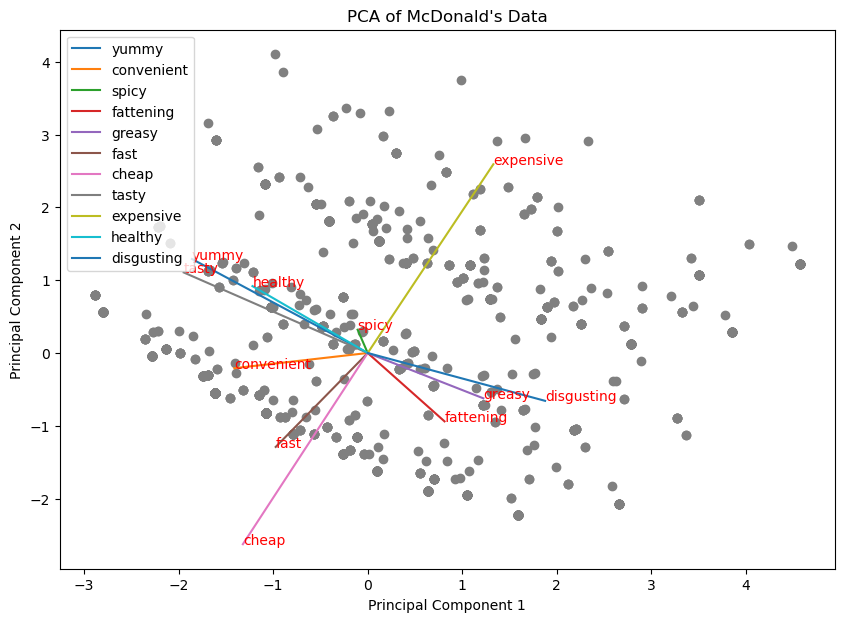

In [6]:
# Plot PCA results
plt.figure(figsize=(10, 7))
plt.scatter(MD_pca_transformed[:, 0], MD_pca_transformed[:, 1], color='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of McDonald\'s Data')

# Function to project original axes on the PCA plot
def proj_axes(pca, original_data, ax):
    for i in range(original_data.shape[1]):
        vector = pca.components_[0:2, i] * max(MD_pca_transformed[:, 0])
        ax.plot([0, vector[0]], [0, vector[1]], label=original_data.columns[i])
        ax.text(vector[0], vector[1], original_data.columns[i], color='red')

ax = plt.gca()
proj_axes(pca, MD_x, ax)
plt.legend()
plt.show()


K-MEANS clustering

In [7]:
# KMeans clustering
best_model = None
best_score = float('inf')
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x_scaled)
    score = kmeans.inertia_
    if score < best_score:
        best_score = score
        best_model = kmeans

cluster_labels = best_model.labels_
data['Cluster'] = cluster_labels
print(data[['Cluster']])

      Cluster
0           7
1           0
2           6
3           0
4           7
...       ...
1448        2
1449        2
1450        3
1451        5
1452        2

[1453 rows x 1 columns]


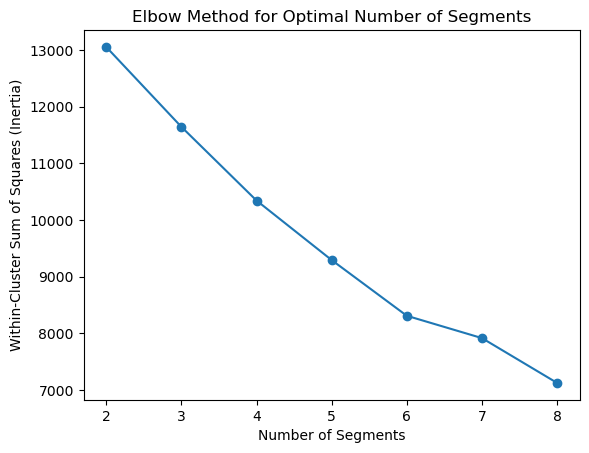

In [8]:
# Elbow method for optimal number of segments
inertia_values = [KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x_scaled).inertia_ for k in range(2, 9)]
plt.plot(range(2, 9), inertia_values, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal Number of Segments')
plt.show()


In [9]:
# Bootstrap adjusted Rand index for optimal number of segments
np.random.seed(1234)
n_boot = 100
adjusted_rand_indices = []
for k in range(2, 9):
    bootstrap_rand_indices = []
    for _ in range(n_boot):
        bootstrap_indices = np.random.choice(len(MD_x_scaled), len(MD_x_scaled), replace=True)
        bootstrap_data = MD_x_scaled[bootstrap_indices]
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
        kmeans.fit(bootstrap_data)
        true_labels = cluster_labels[bootstrap_indices]
        predicted_labels = kmeans.labels_
        rand_index = adjusted_rand_score(true_labels, predicted_labels)
        bootstrap_rand_indices.append(rand_index)
    adjusted_rand_indices.append(np.mean(bootstrap_rand_indices))


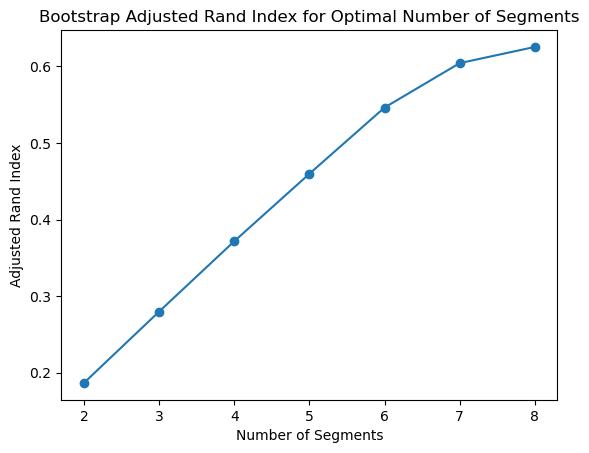

In [10]:
plt.plot(range(2, 9), adjusted_rand_indices, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Bootstrap Adjusted Rand Index for Optimal Number of Segments')
plt.show()


Regression Models

In [11]:
# Gaussian Mixture Models
np.random.seed(1234)
aic_values = []
bic_values = []
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x_scaled)
    aic_values.append(gmm.aic(MD_x_scaled))
    bic_values.append(gmm.bic(MD_x_scaled))

optimal_k = bic_values.index(min(bic_values)) + 2
gmm_optimal = GaussianMixture(n_components=optimal_k, n_init=10, random_state=1234)
gmm_optimal.fit(MD_x_scaled)
gmm_labels = gmm_optimal.predict(MD_x_scaled)

kmeans_optimal = KMeans(n_clusters=optimal_k, n_init=10, random_state=1234)
kmeans_optimal.fit(MD_x_scaled)
kmeans_labels = kmeans_optimal.labels_

contingency_table = pd.crosstab(kmeans_labels, gmm_labels)
print(contingency_table)

col_0    0   1   2   3    4   5    6   7
row_0                                   
0      278   2   0   0   65   3    0   4
1        0  79   0  36    0   0    0   0
2        0   2  98   0    0   0    0   0
3       16   0   0  38  169   4    0   1
4        0   0   0   2  161   0    0   3
5       52   1   2   4    0  92    9  28
6        0   2   1   0    0   0  111   0
7        0   0   0   0  166   0    0  24


In [13]:
like_mapping = {"I hate it!-5": -5, "-4": -4, "-3": -3, "-2": -2, "-1": -1, "0": 0, "+1": 1, "+2": 2, "+3": 3, "+4": 4, "I love it!+5": 5}
data['Like.n'] = data['Like'].map(like_mapping)
data['Like.n'] = 6 - (data['Like.n'] + 5)

features = MD_x.columns[:11]
X = (MD_x == "Yes").astype(int)
y = data['Like.n']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(1234)
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
data['Cluster'] = gmm.fit_predict(X_scaled)

regressions = {}
for cluster in range(2):
    cluster_data = data[data['Cluster'] == cluster]
    cluster_X = (cluster_data[features] == "Yes").astype(int)
    cluster_X_scaled = scaler.fit_transform(cluster_X)
    cluster_y = cluster_data['Like.n']
    reg = LinearRegression()
    reg.fit(cluster_X_scaled, cluster_y)
    regressions[cluster] = reg

In [14]:
for cluster, reg in regressions.items():
    print(f"Cluster {cluster + 1} regression coefficients:")
    print(pd.Series(reg.coef_, index=features))
    print(f"Intercept: {reg.intercept_}")
    print()

Cluster 1 regression coefficients:
yummy        -1.346795
convenient   -0.449381
spicy         0.022630
fattening    -0.014159
greasy       -0.038081
fast         -0.157812
cheap         0.002679
tasty        -0.630387
expensive     0.018037
healthy      -0.104240
disgusting    0.590952
dtype: float64
Intercept: 3.1704834605597965

Cluster 2 regression coefficients:
yummy        -0.966472
convenient    0.000000
spicy         0.141214
fattening     0.179819
greasy        0.180996
fast         -0.061532
cheap        -0.031502
tasty        -0.573522
expensive    -0.005146
healthy      -0.197707
disgusting    0.000000
dtype: float64
Intercept: -0.869811320754717



Profiling Segments

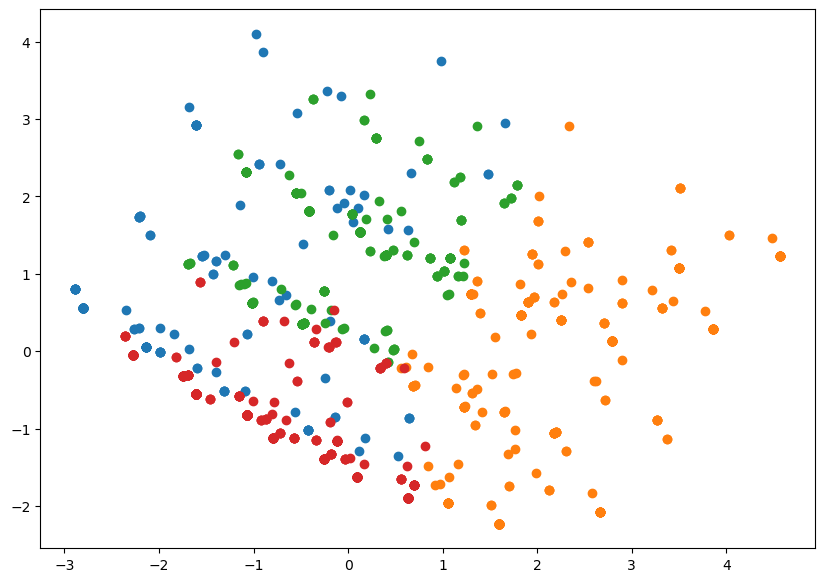

In [15]:
# Profiling segments with KMeans
np.random.seed(1234)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x_scaled)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x_scaled)

plt.figure(figsize=(10, 7))
for i in range(4):
    cluster_points = MD_pca[kmeans_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


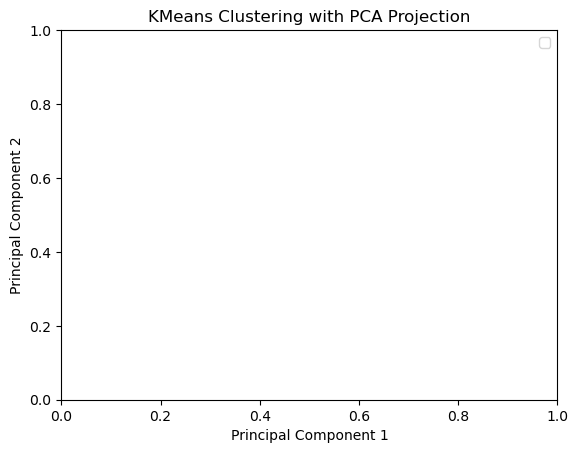

In [16]:
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with PCA Projection')
plt.legend()
plt.show()

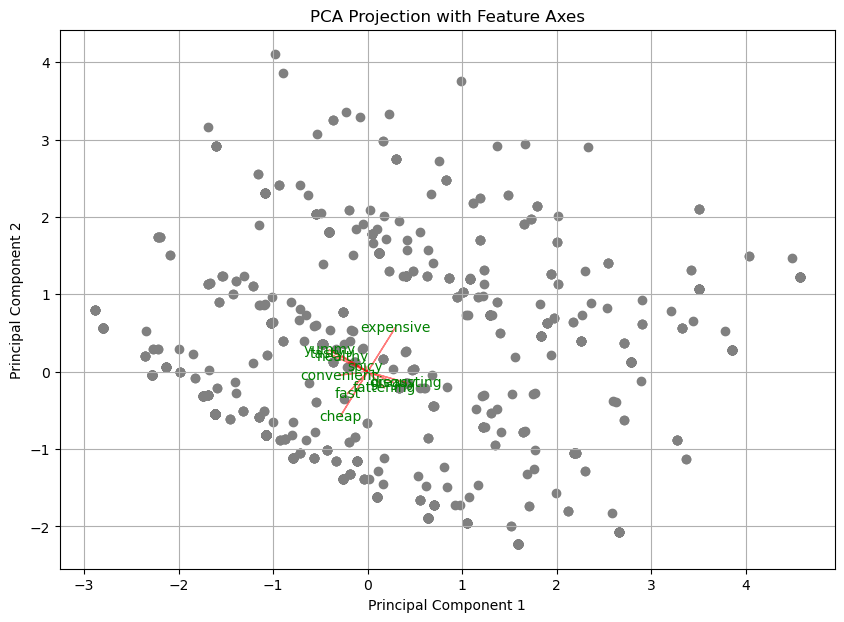

In [17]:
# Project PCA axes
def projAxes(pca_model):
    plt.figure(figsize=(10, 7))
    plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey')
    for i, (x, y) in enumerate(zip(pca_model.components_[0], pca_model.components_[1])):
        plt.arrow(0, 0, x, y, color='r', alpha=0.5)
        plt.text(x, y, f"{MD_x.columns[i]}", color='g', ha='center', va='center')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Projection with Feature Axes')
    plt.grid()
    plt.show()

projAxes(pca)


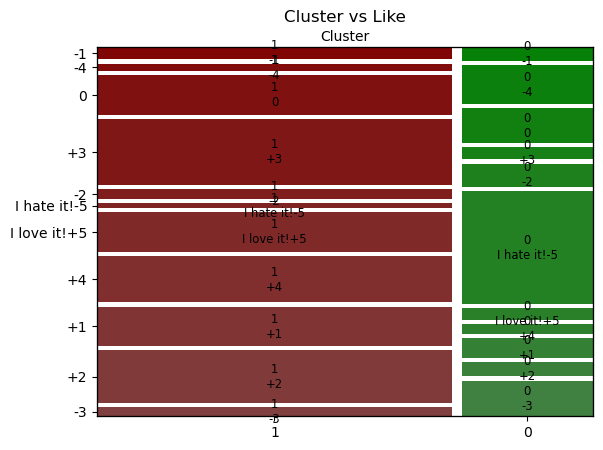

In [18]:
# Mosaic plots for Cluster vs. Like and Gender
mosaic(data, ['Cluster', 'Like'], title='Cluster vs Like', gap=0.02)
plt.xlabel('Cluster')
plt.ylabel('Like')
plt.show()

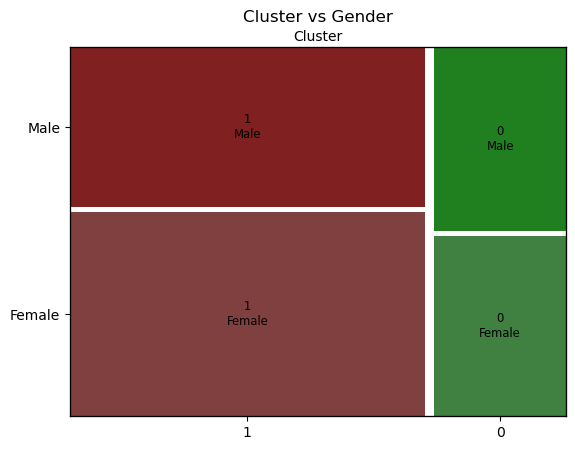

In [19]:
mosaic(data, ['Cluster', 'Gender'], title='Cluster vs Gender', gap=0.02)
plt.xlabel('Cluster')
plt.ylabel('Gender')
plt.show()


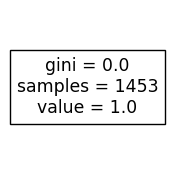

In [23]:
# Decision tree for Cluster 3
data['Cluster3'] = (data['Cluster'] == 3).astype(int)
features = ['Like.n', 'Age', 'VisitFrequency', 'Gender']
data['Gender'] = pd.Categorical(data['Gender']).codes
data['VisitFrequency'] = pd.Categorical(data['VisitFrequency']).codes

tree_model = DecisionTreeClassifier(random_state=1234)
tree_model.fit(data[features], data['Cluster3'])

plt.figure(figsize=(2, 2))
plot_tree(tree_model, feature_names=features, class_names=['Not Cluster 3', 'Cluster 3'], filled=True)
plt.show()


In [24]:
# Profiling clusters
visit_freq_mapping = {"Every day": 1, "Once a week": 2, "Once a month": 3, "Every three months": 4, "Once a year": 5, "Never": 6}
data['VisitFrequency.n'] = data['VisitFrequency'].map(visit_freq_mapping)

visit_mean = data.groupby('Cluster')['VisitFrequency.n'].mean()
like_mean = data.groupby('Cluster')['Like.n'].mean()
female_mean = data.groupby('Cluster')['Gender'].apply(lambda x: (x == 1).mean())

print(visit_mean)
print(like_mean)
print(female_mean)

Cluster
0   NaN
1   NaN
Name: VisitFrequency.n, dtype: float64
Cluster
0    3.170483
1   -0.869811
Name: Like.n, dtype: float64
Cluster
0    0.506361
1    0.439623
Name: Gender, dtype: float64
